In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [6]:
import nltk
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [39]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import regex as re
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier

In [9]:
data = pd.read_csv('/content/emails.csv')      # reading data

In [10]:
data.head()        # checking data

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


### Observing Data

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5728 entries, 0 to 5727
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5728 non-null   object
 1   spam    5728 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.6+ KB


In [12]:
# Checking null/missing values
data.isnull().sum()

text    0
spam    0
dtype: int64

In [13]:
# Checking counts of spams and non-spams
data['spam'].value_counts()

0    4360
1    1368
Name: spam, dtype: int64

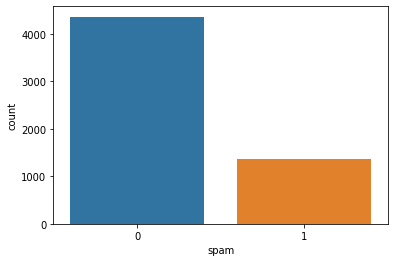

In [14]:
sns.countplot(x="spam", data = data)


In [15]:
data.groupby("spam").describe()


text                                                               
     count unique                                                top freq
spam                                                                     
0     4360   4327  Subject: * special notification * aurora versi...    2
1     1368   1368  Subject: naturally irresistible your corporate...    1

### Preprocessing

In [16]:
# Removing Punctutaion
def remove_punctuation(text):
    no_punct="".join([words for words in text if words not in string.punctuation])
    return no_punct
data["text"] = data['text'].apply(lambda x: remove_punctuation(x))
data.head()

,text,spam
0,Subject naturally irresistible your corporate ...,1
1,Subject the stock trading gunslinger fanny is...,1
2,Subject unbelievable new homes made easy im w...,1
3,Subject 4 color printing special request addi...,1
4,Subject do not have money get software cds fr...,1


In [17]:
# Removing Stopwords
stopword = set(stopwords.words('english'))
stopword.add('Subject')
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopword])
data['text'] = data['text'].apply(lambda x: remove_stopwords(x))
data.head()

,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new homes made easy im wanting sh...,1
3,4 color printing special request additional in...,1
4,money get software cds software compatibility ...,1


In [18]:
# Tokenizing
'''Tokenization is the process of breaking text into smaller pieces called tokens. 
These smaller pieces can be sentences, words, or sub-words.'''
def tokenize(text):
    split=re.split("\W+",text) 
    return split
data['text']=data['text'].apply(lambda x: tokenize(x.lower()))
data.head()

,text,spam
0,"[naturally, irresistible, corporate, identity,...",1
1,"[stock, trading, gunslinger, fanny, merrill, m...",1
2,"[unbelievable, new, homes, made, easy, im, wan...",1
3,"[4, color, printing, special, request, additio...",1
4,"[money, get, software, cds, software, compatib...",1


In [19]:
# Lemmatizing
'''Lemmatizing is the process of reducing a word to its root form.'''
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text])

data['text'] = data["text"].apply(lambda text: lemmatize_words(text))
data.head()

,text,spam
0,naturally irresistible corporate identity lt r...,1
1,stock trading gunslinger fanny merrill muzo co...,1
2,unbelievable new home made easy im wanting sho...,1
3,4 color printing special request additional in...,1
4,money get software cd software compatibility g...,1


In [20]:
# Splitting the data according to spam and non-spam 
spam = " ".join(data[data['spam'] == 1]['text'].tolist())
non_spam = " ".join(data[data['spam'] == 0]['text'].tolist())

# Common Words

In [21]:
# Finding most repeated words in the data
def return_top_words(text,words = 10):
    allWords = nltk.tokenize.word_tokenize(text)
    stopwords = nltk.corpus.stopwords.words('english')
    allWordExceptStopDist = nltk.FreqDist(w.lower() for w in allWords if w not in stopwords)    
    mostCommontuples= allWordExceptStopDist.most_common(words)
    mostCommon = [tupl[0] for tupl in mostCommontuples]
    return mostCommon

In [22]:
top_10_spam = return_top_words(spam,10)
top_10_non_spam = return_top_words(non_spam,10)

In [23]:
print(top_10_spam)
print(top_10_non_spam)

['company', 'com', '1', 'business', 'email', 'information', 'e', 'u', '5', 'money']
['enron', 'ect', 'vince', 'hou', '2000', 'kaminski', 'com', 'please', 'subject', 'would']


### WordCloud

In [24]:
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in data.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(spam) 

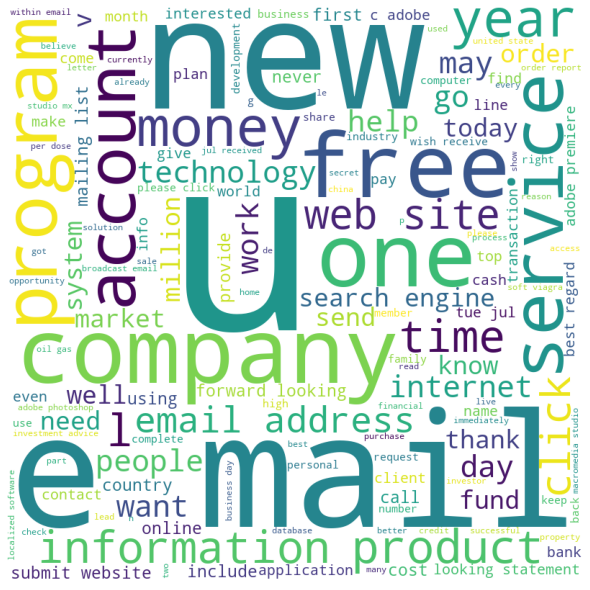

In [25]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [26]:
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in data.text: 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
      
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(non_spam) 

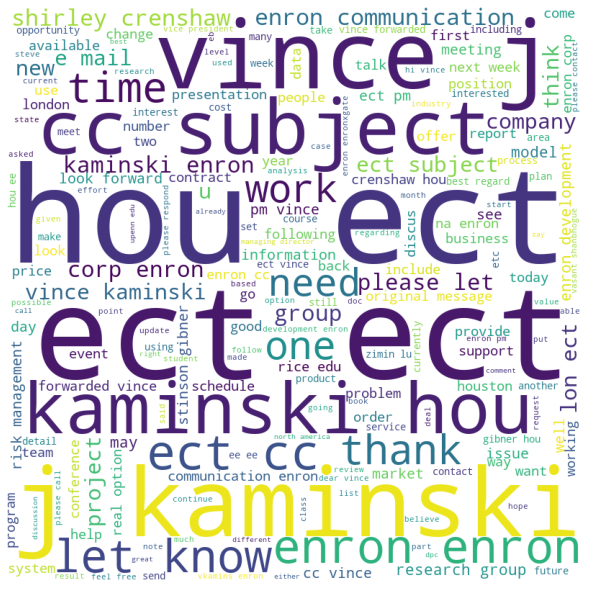

In [27]:
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

In [28]:
X = data['text']
y = data['spam']

## TF-IDF(Tokenization Algorithms) 

In [42]:
# TF-IDF (Term Frequency - Inverse Document Frequency)
'''This is a technique to quantify a word in documents, we generally compute a weight to each word
which signifies the importance of the word in the document and corpus. 
This method is a widely used technique in Information Retrieval and Text Mining.'''
vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X_ct  = vectorizer.transform(X)

# Splitting Data into Test and Train 

In [43]:
# Splitting the data
X_train,X_test,y_train,y_test = train_test_split(X_ct,y,test_size=0.2,random_state=42)

In [44]:
print(X_train.shape)
print(y_train.shape)

(4582, 34579)
(4582,)


In [45]:
print(X_test.shape)
print(y_test.shape)

(1146, 34579)
(1146,)


### **Implementation of Classifier Algorithms**

### **Naive Bayes**

In [46]:
nb= MultinomialNB()
nb.fit(X_train,y_train)
y_pred2 = nb.predict(X_test)
print("accuracy score is: ",accuracy_score(y_test,y_pred2))
print(classification_report(y_test,y_pred2))

accuracy score is:  0.8856893542757417
              precision    recall  f1-score   support

           0       0.87      1.00      0.93       856
           1       1.00      0.55      0.71       290

    accuracy                           0.89      1146
   macro avg       0.93      0.77      0.82      1146
weighted avg       0.90      0.89      0.87      1146



#### Accuracy score for Naive Bayes Classifier is 89%

### Random Forest

In [47]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred3 = rf.predict(X_test)
print("accuracy score is: ",accuracy_score(y_test,y_pred3))
print(classification_report(y_test,y_pred3))

accuracy score is:  0.9781849912739965
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       856
           1       1.00      0.91      0.95       290

    accuracy                           0.98      1146
   macro avg       0.99      0.96      0.97      1146
weighted avg       0.98      0.98      0.98      1146



#### Accuracy Score for Random Forest is 97%

### XGBoost

In [48]:
xg = XGBClassifier()
xg.fit(X_train, y_train)
y_pred4 = xg.predict(X_test)
print("accuracy score is: ",accuracy_score(y_test,y_pred4))
print(classification_report(y_test,y_pred4))

accuracy score is:  0.9677137870855148
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       856
           1       0.91      0.97      0.94       290

    accuracy                           0.97      1146
   macro avg       0.95      0.97      0.96      1146
weighted avg       0.97      0.97      0.97      1146



#### Accuracy Score for XGBoost is 98%

In [50]:
clf = MultinomialNB(alpha = 0.001)
auc = get_auc_CV(clf,X_train, y_train)
print(auc)

0.9996103313184228
